<a href="https://colab.research.google.com/github/Jolie-Ni/GenAISearchEngine/blob/main/ai-performance-eval-agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Performance Eval Assistant

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the performance eval report process.
  
`Planning`
* Users provide a person of interest and a performance eval guideline to generate performance review on, and the system generates a team of AI analysts, each focusing on one aspect of the performance eval.
* `Human-in-the-loop` will be used to refine these aspects before analysis begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth conversation with our enterprise knowledge base.
* The interview will be a multi-turn conversation to extract detailed insights.
* These conversation will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* knowledge base will gather information to answer analyst questions in `parallel`.
* And all conversation will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each conversation will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

LANGCHAIN_API_KEY: ··········


## Generate Analysts:

*   List item
*   List item



Create analysts

In [33]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    name: str = Field(
        description="Name of the analyst."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their names and descriptions.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # person of interest
    guideline: str # performance review guideline
    max_analysts: int # Number of analysts
    analysts: List[Analyst] # Analyst asking questions

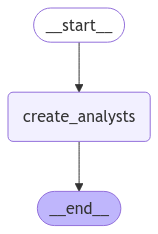

In [36]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas that research about an employee's performance given performance review guideline. Follow these instructions carefully:

1. You are given a performance review guideline that contains expections of software engineers in different levels
{guideline}


3. The guideline contains several aspects that evaluates an employee's performance, carefully read through each aspect's description

4. Assign one analyst to each aspect."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """
    topic=state["topic"]
    guideline=state['guideline']
    max_analysts=state['max_analysts']

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(guideline=guideline,max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [38]:
# Input
max_analysts = 3
topic="Amy"
guideline = """
Scope and Impact:
L3: Develops features with supervision and support.
L4: Designs, develops, ships, and maintains features with support.
L5: Designs, develops, ships, and maintains medium-sized features independently.
L6: Leads medium-to-large features and multi-person efforts, usually crossing engineering team boundaries.
Technical Contributions:
L3: With supervision, implements code that is clear, concise, and tested.
L4: With support, implements code that is clear, concise, and tested.
L5: Independently implements code that is clear, concise, and tested.
L6: Makes high-quality, impactful technical contributions. Analyzes and resolves technical obstacles for the team.
Expertise:
L3: Is learning one or more technical areas.
L4: Is proficient in one or more technical areas.
L5: Is highly proficient in one or more technical areas.
L6: Is an expert in one or more technical areas. An excellent source of insights and wisdom within the team.
Design & Architecture:
L3: With supervision, participates in engineering design for features and bug fixes.
L4: With support, contributes to engineering design for features and bug fixes. Provides meaningful feedback on other engineers’ code.
L5: Creates or co-creates engineering designs. Provides meaningful feedback on other engineers’ designs and code.
L6: Leads engineering designs, soliciting feedback and building consensus. Provides meaningful feedback and guides other engineers to resolve open questions in designs and code.
Ownership:
L3: Responsible for development and testing of their code.
L4: Responsible for development, testing, rollout, and maintenance of their code. Improves the health and quality of the code.
L5: Responsible for the successful delivery of projects, including planning, risk management, design, development, testing, rollout, and maintenance. Ensures long-term health and quality of the team’s codebase and systems.
L6: Responsible for the successful delivery of projects, including coordination, planning, risk management, design, development, testing, rollout, and maintenance.
"""
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic, "guideline":guideline, "max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Scope and Impact Analyst
Description: Focuses on evaluating the breadth and depth of an engineer's contributions to feature development and team efforts. Concerned with how independently and effectively the engineer can lead projects and collaborate across teams.
--------------------------------------------------
Name: Technical Contributions Analyst
Description: Specializes in assessing the quality and impact of the engineer's code. Looks for clarity, conciseness, and thorough testing in the engineer's technical outputs, as well as their ability to overcome technical challenges.
--------------------------------------------------
Name: Expertise Analyst
Description: Concentrates on the engineer's proficiency and expertise in technical areas. Evaluates how well the engineer can provide insights and wisdom to the team, and their growth in technical knowledge.
--------------------------------------------------
Name: Design & Architecture Analyst
Description: Examines the engineer's 

In [39]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Scope and Impact Analyst
Description: Focuses on evaluating the breadth and depth of an employee's contributions to projects and features. Concerned with how independently and effectively the employee can lead and execute tasks, as well as their ability to collaborate across teams.
--------------------------------------------------
Name: Technical Contributions Analyst
Description: Specializes in assessing the quality and clarity of the code written by the employee. Looks at how independently the employee can implement solutions and their ability to overcome technical challenges.
--------------------------------------------------
Name: Expertise Analyst
Description: Concentrates on the employee's proficiency and expertise in technical areas. Evaluates how the employee's knowledge contributes to the team and their role as a source of insights and wisdom.
--------------------------------------------------
Name: Design & Architecture Analyst
Description: Examines the employee's invo

In [40]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [41]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [42]:
final_state.next

()

In [43]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Scope and Impact Analyst
Description: Focuses on evaluating the breadth and depth of an employee's contributions to projects and features. Concerned with how independently and effectively the employee can lead and execute tasks, as well as their ability to collaborate across teams.
--------------------------------------------------
Name: Technical Contributions Analyst
Description: Specializes in assessing the quality and clarity of the code written by the employee. Looks at how independently the employee can implement solutions and their ability to overcome technical challenges.
--------------------------------------------------
Name: Expertise Analyst
Description: Concentrates on the employee's proficiency and expertise in technical areas. Evaluates how the employee's knowledge contributes to the team and their role as a source of insights and wisdom.
--------------------------------------------------
Name: Design & Architecture Analyst
Description: Examines the employee's invo

## Conduct Interview

### Generate Question

The analyst will ask questions to discover more about this person's performance.

In [44]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [45]:
question_instructions = """You are an analyst tasked with asking a knowledge base question to discover more about an employee's performance.

Your goal is boil down to specific strengths and weaknesses of this employee related to the aspect of performance guideline you are researching.

1. Strengths: What are something this person is doing particularlly good at that receives a lot of compliments?

2. Weaknesses: What are things this person get a lot of constructive feedback on consistently?

Here is your aspect of focus and set of goals: {goals}

Begin by understanding what does a good software enginner look like in this aspect?

Continue to ask questions to drill down and refine your understanding of this person's performance.

When you are satisfied with your understanding, complete the interview with: "I am done!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [16]:
!pip install -qU langchain-openai
!pip install langchain_chroma
!pip install playwright

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.2 MB/s eta 0:00:00


In [46]:
github_data = """
We have 3 software engineers:

- **Amy’s Work**: Python backend for the to-do list feature, with clean, modular code.
- **Daniel’s Work**: Bug fixes in retrieval API endpoints, with messy and poorly structured code.
- **Joe’s Work**: Frontend to-do list in TypeScript, clean but scoped.

### Amy's Contributions

### Commit History:

1. **2024-11-17 17:56:07** - *"Setup database schema for the to-do list feature."*
2. **2024-11-16 11:56:07** - *"Add CRUD operations for to-do items."*
3. **2024-11-16 13:56:07** - *"Implement service methods for creating and retrieving to-do items."*
4. **2024-11-16 15:56:07** - *"Add unit tests for to-do service."*
5. **2024-11-16 10:56:07** - *"Improve type hints and docstrings for better maintainability."*
6. **2024-11-17 13:56:07** - *"Handle edge cases for updating to-do items."*
7. **2024-11-17 06:56:07** - *"Add input validation for due date and title fields."*
8. **2024-11-16 07:56:07** - *"Implement error handling for database exceptions."*
9. **2024-11-16 14:56:07** - *"Optimize query performance for bulk retrieval."*
10. **2024-11-16 14:56:07** - *"Add repr method for debugging and readability."*
11. **2024-11-16 17:56:07** - *"Fix a minor bug in delete operation logic."*
12. **2024-11-17 12:56:07** - *"Update test cases for enhanced coverage."*
13. **2024-11-17 06:56:07** - *"Add feature toggle for incomplete items only."*
14. **2024-11-16 07:56:07** - *"Document API endpoints for the to-do list feature."*
15. **2024-11-17 06:56:07** - *"Finalize feature for PR submission."*

### Code Snippets:

**1. `models/todo.py` (Database Schema):**

```python
python
Copy code
from sqlalchemy import Column, Integer, String, DateTime
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

class TodoItem(Base):
    __tablename__ = 'todo_items'
    id = Column(Integer, primary_key=True, autoincrement=True)
    title = Column(String(255), nullable=False)
    description = Column(String(1024), nullable=True)
    due_date = Column(DateTime, nullable=True)
    is_completed = Column(Integer, default=0)

    def __repr__(self):
        return f"<TodoItem(id={self.id}, title={self.title})>"

```

**2. `services/todo_service.py` (CRUD Operations):**

```python
python
Copy code
from models.todo import TodoItem
from sqlalchemy.orm import Session

def create_todo(session: Session, title: str, description: str = None, due_date: str = None):
    todo_item = TodoItem(title=title, description=description, due_date=due_date)
    session.add(todo_item)
    session.commit()
    return todo_item

def get_todo(session: Session, todo_id: int):
    return session.query(TodoItem).filter(TodoItem.id == todo_id).first()

def update_todo(session: Session, todo_id: int, **kwargs):
    todo_item = get_todo(session, todo_id)
    if not todo_item:
        return None
    for key, value in kwargs.items():
        setattr(todo_item, key, value)
    session.commit()
    return todo_item

def delete_todo(session: Session, todo_id: int):
    todo_item = get_todo(session, todo_id)
    if not todo_item:
        return False
    session.delete(todo_item)
    session.commit()
    return True

```

**3. `tests/test_todo_service.py` (Unit Tests):**

```python
python
Copy code
import pytest
from services.todo_service import create_todo, get_todo, update_todo, delete_todo
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from models.todo import Base

@pytest.fixture
def session():
    engine = create_engine("sqlite:///:memory:")
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    return Session()

def test_create_todo(session):
    todo = create_todo(session, title="Test Task", description="Testing", due_date="2024-11-30")
    assert todo.id is not None
    assert todo.title == "Test Task"

def test_get_todo(session):
    todo = create_todo(session, title="Test Task")
    fetched = get_todo(session, todo.id)
    assert fetched.title == "Test Task"

def test_update_todo(session):
    todo = create_todo(session, title="Test Task")
    updated = update_todo(session, todo.id, title="Updated Task")
    assert updated.title == "Updated Task"

def test_delete_todo(session):
    todo = create_todo(session, title="Test Task")
    result = delete_todo(session, todo.id)
    assert result is True

```

========================================================================

### Daniel's Contributions (12 Commits)

### Commit History:

1. **2024-11-16 15:04:11** - *"Fix retrieval API for to-do items."*
2. **2024-11-16 04:04:11** - *"Patch for incorrect error handling in retrieval API."*
3. **2024-11-16 11:04:11** - *"Added pagination to to-do retrieval (incomplete)."*
4. **2024-11-16 03:04:11** - *"Refactor query filters."*
5. **2024-11-16 09:04:11** - *"Resolve API response inconsistency issue."*
6. **2024-11-16 07:04:11** - *"Basic testing for retrieval API endpoints."*
7. **2024-11-17 09:04:11** - *"Fix edge case for non-existent IDs."*
8. **2024-11-16 21:04:11** - *"Missing session close in pagination."*
9. **2024-11-17 07:04:11** - *"Handle type conversion error for IDs."*
10. **2024-11-17 08:04:11** - *"Address comments about API response format."*
11. **2024-11-16 03:04:11** - *"Add basic comments."*
12. **2024-11-16 16:04:11** - *"PR update with minor fixes in retrieval API."*

### Code Snippets:

**1. `api/retrieval.py` (Retrieval API):**

```python
python
Copy code
from flask import Flask, jsonify, request
from models.todo import TodoItem
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine

engine = create_engine("sqlite:///example.db")
Session = sessionmaker(bind=engine)
app = Flask(__name__)

@app.route('/api/todos/<int:id>', methods=['GET'])
def get_todo_by_id(id):
   session=Session()
   todo=session.query(TodoItem).filter(TodoItem.id==id).first()
   if not todo:
      return jsonify({"error":"todo not found"}),404
   return jsonify({"id":todo.id,"title":todo.title,"description":todo.description,"due_date":str(todo.due_date),"is_completed":todo.is_completed})

```

**2. `api/pagination.py` (Pagination Code):**

```python
python
Copy code
from flask import Flask, request, jsonify
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from models.todo import TodoItem

engine = create_engine("sqlite:///example.db")
Session = sessionmaker(bind=engine)
app = Flask(__name__)

@app.route('/api/todos', methods=['GET'])
def get_paginated_todos():
    session = Session()
    try:
        page = int(request.args.get('page', 1))
        per_page = int(request.args.get('per_page', 10))
        offset = (page - 1) * per_page
        todos = session.query(TodoItem).offset(offset).limit(per_page).all()
        result = []
        for todo in todos:
            result.append({
                "id": todo.id,
                "title": todo.title,
                "description": todo.description,
                "due_date": str(todo.due_date),
                "is_completed": todo.is_completed
            })
        return jsonify(result)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

```

**3. `api/response_fix.py` (Fixed Response Format):**

```python
python
Copy code
from flask import Flask, jsonify
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from models.todo import TodoItem

engine = create_engine("sqlite:///example.db")
Session = sessionmaker(bind=engine)
app = Flask(__name__)

@app.route('/api/todos/<int:id>', methods=['GET'])
def fixed_get_todo_by_id(id):
    session = Session()
    todo = session.query(TodoItem).filter(TodoItem.id == id).first()
    if not todo:
        return jsonify({"status": "failure", "message": "To-do item not found"})
    return jsonify({"status": "success", "data": {
        "id": todo.id,
        "title": todo.title,
        "description": todo.description,
        "due_date": str(todo.due_date),
        "is_completed": todo.is_completed
    }})

```

PR reviews Daneil got:

Below are the comments provided during the code review for Daniel's contributions. These comments reflect feedback from Amy, a senior engineer, focusing on improving code quality and consistency.

---

### Feedback for `api/retrieval.py`

**Reviewer:** *Amy*

**Comment:**

- "The function `get_todo_by_id` is missing proper exception handling. Please ensure that the session is properly closed even in case of errors."
- "Indentation for the code block inside the `if not todo` condition is inconsistent. Consider formatting this to align with PEP 8 standards."
- "The response structure can be standardized. For example, even in error cases, include a status field to match the success responses."

---

### Feedback for `api/pagination.py`

**Reviewer:** *Amy*

**Comment:**

- "Ensure that the session is closed after the query execution to prevent resource leaks."
- "Consider extracting the pagination logic into a helper function to improve code readability and reusability."
- "The exception handling block is too generic. Use specific exception types where possible to provide more meaningful error messages."
- "Some variables, like `result`, could benefit from a more descriptive name to indicate their purpose, e.g., `todos_list`."

---

### Feedback for `api/response_fix.py`

**Reviewer:** *Amy*

**Comment:**

- "The structure of the success response is well-organized, but consider adding a `timestamp` field to help clients handle stale responses."
- "Use a context manager (`with session:`) instead of manually opening and closing sessions. This ensures proper cleanup and makes the code less error-prone."
- "Avoid hardcoding the string keys in the response dictionary repeatedly. Define constants or use a response formatter function to avoid typos and improve maintainability."

=======================================================================

### Joe’s contribution(18 commits)

- **2024-11-16 10:09:58** - *"Initialize Todo List component and…"""

In [47]:
# index document
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_text(github_data)
vectorstore = Chroma.from_texts(texts=chunks, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


github_knowledge_base = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [48]:
github_knowledge_base.invoke("How many commit Amy has?")

'Amy has five commits.'

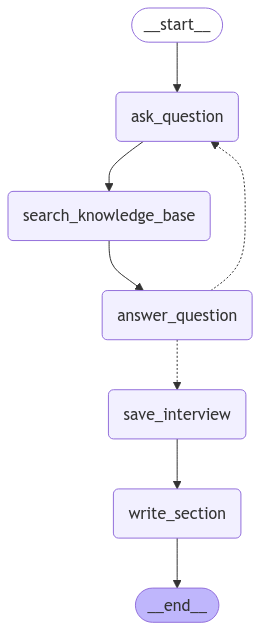

In [49]:
from langchain_core.messages import get_buffer_string


answer_instructions = """You are a knowledge base being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the analyst.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and a knowledge base.

Your goal is to generate a well-structured question for use in retrieval related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured question""")

def search_knowledge_base(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    search_docs = github_knowledge_base.invoke(search_query.search_query)
    formatted_search_docs = search_docs
    return {"context": [formatted_search_docs]}

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "knowledge_base"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # print("# responses: " + str(num_responses))
    # print("max turn:" + str(max_num_turns))

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "I am done" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert performance review writer.

Your task is to create a short, easily digestible section of a performance review based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_knowledge_base", search_knowledge_base)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_knowledge_base")
interview_builder.add_edge("search_knowledge_base", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [50]:
# Pick one analyst
analysts[0]

Analyst(name='Scope and Impact Analyst', description="Focuses on evaluating the breadth and depth of an employee's contributions to projects and features. Concerned with how independently and effectively the employee can lead and execute tasks, as well as their ability to collaborate across teams.")

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [51]:
from IPython.display import Markdown
messages = [HumanMessage(f"I want to know more about the performance of {topic}")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 3}, thread)
Markdown(interview['sections'][0])

## Performance Review: Amy

### Summary

Amy's performance as a senior engineer is marked by her exceptional skills in task execution and team collaboration, particularly in the development of the Python backend for the to-do list feature. Her work is characterized by clean, modular code, which not only enhances the functionality of the application but also sets a standard for code quality within the team. This focus on high-quality code is a testament to her technical expertise and attention to detail, which are crucial in maintaining the integrity and performance of the software.

One of the most notable aspects of Amy's performance is her ability to provide constructive feedback during code reviews. This feedback is detailed and aimed at improving code quality and consistency across the team. Her approach to code reviews not only helps in identifying potential issues early but also fosters a culture of continuous improvement and learning among her peers. This is particularly important in a collaborative environment where team members rely on each other to produce the best possible outcomes.

Amy's leadership skills are evident in her role as a senior engineer, where she provides guidance to her team. Her leadership is not just about directing tasks but also about mentoring her colleagues to enhance their coding skills and understanding of best practices. This role is crucial in ensuring that the team adheres to high standards of code quality and consistency, which ultimately contributes to the overall success of the projects they undertake.

Interestingly, the context provided does not highlight any specific weaknesses in Amy's leadership or collaboration. This absence of noted weaknesses suggests that her performance is consistently strong across these areas. However, it also presents an opportunity for further exploration to ensure that any potential areas for improvement are identified and addressed proactively.

In summary, Amy's performance is distinguished by her technical proficiency, her ability to collaborate effectively with her team, and her leadership in guiding her peers towards achieving high standards of code quality. Her contributions are invaluable to the team's success, and her role as a senior engineer is pivotal in maintaining the team's performance and cohesion.

### Sources
[1] Amy's performance shows strengths in task execution and team collaboration, as evidenced by her clean, modular code for the Python backend and her constructive feedback during code reviews.  
[2] Amy's performance is characterized by her work on the Python backend for the to-do list feature, which is noted for being clean and modular. Her strengths include writing well-structured code and providing detailed, constructive feedback during code reviews to improve code quality and consistency.

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [52]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # who's performance review is this?
    guideline: str # performance review guideline
    max_analysts: int # Number of analysts
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

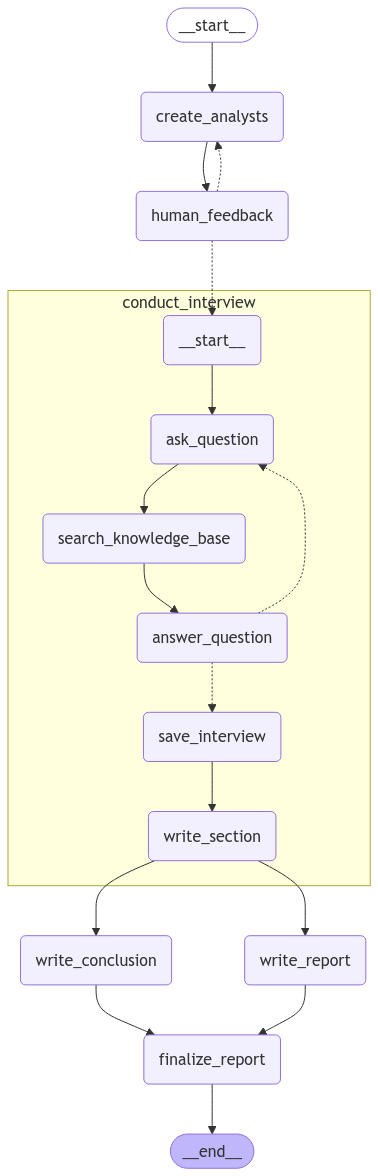

In [68]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Otherwise kick off interviews in parallel via Send() API
    topic = state["topic"]
    return [Send("conduct_interview", {"analyst": analyst,"messages": [HumanMessage(content=f"I want to know more about the performance of {topic}")]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a performance review writer creating a report on performance eval of this person:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with the knowledge base on a specific aspect of the performance review.
2. They write up their finding into a section.

Your task:

1. You will be given a collection of sections from your analysts.
2. Think carefully about the insights from each section.
3. Consolidate these into a crisp overall summary that ties together each section.
4. Summarize the strength and weaknesses of this person.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the sections from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a performance review writer finishing a evaluation on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [69]:
# Inputs
max_analysts = 3
topic = "Amy"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({
                          "topic":topic,
                          "guideline":guideline,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Scope and Impact Analyst
Description: Focuses on evaluating the breadth and depth of an employee's contributions to projects and features. Concerned with how independently and effectively the employee can develop and maintain features, as well as their ability to lead and collaborate on larger projects.
--------------------------------------------------
Name: Technical Contributions Analyst
Description: Specializes in assessing the quality and clarity of the code written by the employee. Looks at how independently the employee can implement code and their ability to resolve technical challenges, ensuring the code is well-tested and impactful.
--------------------------------------------------
Name: Expertise Analyst
Description: Concentrates on the employee's proficiency and expertise in technical areas. Evaluates how the employee's knowledge contributes to the team, and whether they are a source of insights and wisdom.
--------------------------------------------------
Name: Des

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-rviP6Rmw0KxzNUPEH9KEJHKf on tokens per min (TPM): Limit 30000, Used 28127, Requested 2157. Please try again in 568ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

<IPython.core.display.Markdown object>

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r